<a href="https://colab.research.google.com/github.com/EmicoBinsfinder/ImperialReCoDe/blob/main/Multilayer_Perceptron_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Text Classification with a MultiLayer Perceptron

From this notebook, you can learn:
- What a Multilayer Perceptron is, and how they can be used for text classification.
- How to train a Multilayer Perceptron using Tensorflow's Keras.
- Making predictions using a Multilayer Perceptron.
- What are hyperparameters and how do they affect the training and performance of machine learning models.
- Optimise a model's training pipeline using Callbacks
- Visualise a model and plotting training loss curves.
- Visualising the structure of a compiled model.
- Evaluating the performance of a MultiLayer Perceptron.

#What is a Multilayer Perceptron

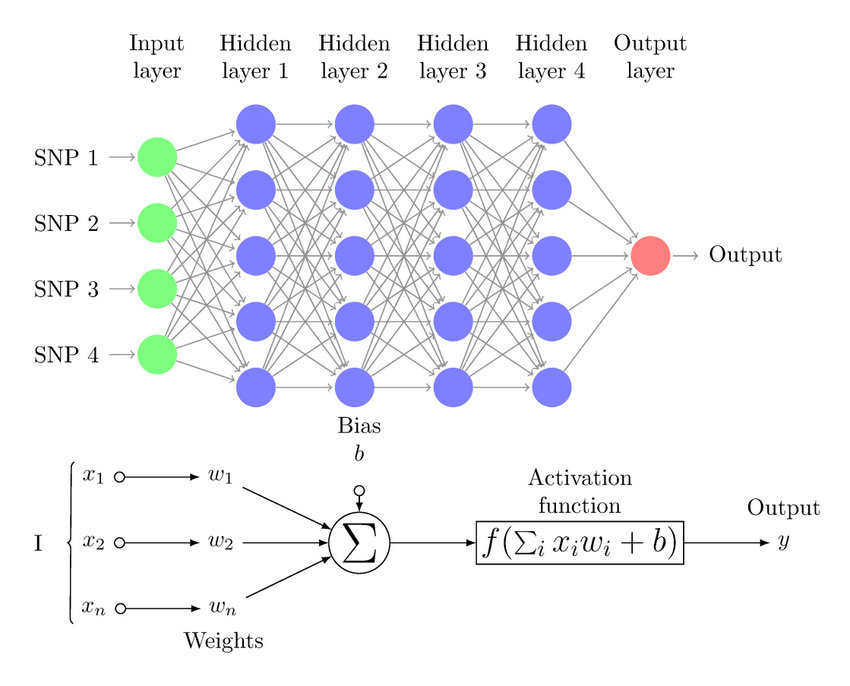

Source: [A Guide for Using Deep Learning for Complex Trait Genomic Prediction - Miguel Pérez-Enciso](https://pubmed.ncbi.nlm.nih.gov/31330861/)

A Multilayer Perceptron (MLP) is a type of artificial neural network (ANN) that consists of multiple layers of interconnected artificial neurons, called nodes or units. It is a feedforward neural network, meaning that, when making predictions information flows in one direction, from input to output.

The MLP is composed of three main types of layers:

1.   Input Layer: It receives the input data and passes it to the next layer. Each neuron in the input layer represents a feature or attribute of the input.

2.   Hidden Layers: These are intermediate layers between the input and output layers. Each hidden layer consists of multiple neurons that process the input data using weighted connections. These connections store the learned knowledge of the network. The hidden layers are responsible for capturing complex patterns and representations in the data.

3. Output Layer: It produces the final output of the network. The number of neurons in the output layer depends on the task at hand. For example, in a binary classification problem, there would be a single output neuron that represents the probability of belonging to one class or the other. In multi-class classification, there would be multiple output neurons, each representing the probability of belonging to a specific class.

During the training phase, an MLP learns by adjusting the weights of the connections between neurons based on the input data and the desired output. This process is typically done using a technique called backpropagation, where the error between the predicted output and the desired output is used to update the weights. The goal is to minimize the difference between the predicted output and the true output by iteratively adjusting the weights through multiple training examples.


MLPs are known for their ability to model complex relationships and solve a wide range of machine learning problems, including classification, regression, and pattern recognition. They are flexible and can handle non-linear relationships in the data, making them suitable for tasks such as image recognition, natural language processing, and recommendation systems.

If you would like to know more about the backpropagation, check out the following resources:

[Understanding the Backpropagation Algorithm](https://towardsdatascience.com/understanding-backpropagation-algorithm-7bb3aa2f95fd)

[Implementing Backpropagation in Tensorflow](https://saturncloud.io/blog/guided-backpropagation-in-tensorflow-a-comprehensive-guide/)

#Importing the modules we will be using

In [ ]:
!git clone https://github.com/ImperialCollegeLondon/ReCoDE-AIForPatents.git

Cloning into 'ImperialReCoDe'...
remote: Enumerating objects: 126, done.
remote: Counting objects: 100% (126/126), done.
remote: Compressing objects: 100% (123/123), done.
remote: Total 126 (delta 69), reused 5 (delta 1), pack-reused 0
Receiving objects: 100% (126/126), 31.70 MiB | 12.54 MiB/s, done.
Resolving deltas: 100% (69/69), done.


In [ ]:
##### MODULE IMPORTS #####
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import torch
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

#Loading the dataset into the workspace and preparing it for use with the ML model

If you want to learn more about how we prepare the data for use with the model that we train, refer to the Introduction notebook.

In [ ]:
def loaddata(GreenCSV, NotGreenCSV):

  """
  Function to create a training dataset and a validation dataset (the validation
  dataset will be kept aside for when we want to evaluate model, to prevent data
  leakage)
  """

  n=90 #percentage of data that will be used during the training of the machine learning model

  #Read in first dataframe
  GreenData_Dataframe = pd.read_csv(GreenCSV)

  #Read in second dataframe
  NotGreenDataFrame = pd.read_csv(NotGreenCSV)

  #Make sure equal number of entries
  MergedDataFrame = pd.concat([GreenData_Dataframe, NotGreenDataFrame[0:len(GreenData_Dataframe)]])

  MergedDataFrame = MergedDataFrame.sample(frac=1, random_state=25) #Shuffle dataframe

  #Get n percent first rows of merged dataframe
  TrainingDataFrame = MergedDataFrame.head(int(len(MergedDataFrame)*(n/100)))

  #Get n percent last rows of merged dataframe
  ValidationDataframe = MergedDataFrame.tail(int(len(MergedDataFrame)*((100-n)/100)))

  #Shuffle dataframe
  FinalDataframe = TrainingDataFrame.sample(frac=1, random_state=25)

  #Shuffle validation dataframe
  ValidationDataframe = ValidationDataframe.sample(frac=1, random_state=25)



  return FinalDataframe, ValidationDataframe

FinalDataframe, ValidationDataframe = loaddata('/content/ReCoDE-AIForPatents/Datasets/GreenPatents_Dataset.csv',
                          '/content/ReCoDE-AIForPatents/Datasets/NotGreenPatents_Dataset.csv')


# Checking for duplicates
total_duplicate_titles = sum(FinalDataframe["Abstract"].duplicated())

# Deleting duplicates
FinalDataframe = FinalDataframe[~FinalDataframe["Abstract"].duplicated()] #Deleting Duplicate values
FinalDataframe = FinalDataframe.dropna() #Deleting Nan values

X_train, X_test, y_train, y_test = train_test_split(
    FinalDataframe["Abstract"].to_numpy(),
    FinalDataframe["GreenV"].to_numpy(),
    test_size=0.1, # 10% of sample in test dataset
    random_state=25)

X_val, X_valnull, Y_val, Y_valnull = train_test_split(
    ValidationDataframe["Abstract"].to_numpy(),
    ValidationDataframe["GreenV"].to_numpy(),
    test_size=0.0001, #Creating dataset for validation
    random_state=25)

# Setting up the Text Vectoriser
text_vectoriser = TextVectorization(
    max_tokens=None, #How many words in the vocabulary (all of the different words in your text)
    standardize="lower_and_strip_punctuation", #How to pre-process text
    split="whitespace", #How to split tokens
    ngrams=None, #Create groups of n-words
    output_mode="int", #How to map tokens to numbers
    output_sequence_length=200) #Based on length of majority of abstracts
    # pad_to_max_tokens=True) # Not valid if using max_tokens= None

#Making inputs compatible with TextVectorisation Layer
X_train = [str(x) for x in X_train]
X_test = [str(x) for x in X_test]
X_train = np.array(X_train)
X_test = np.array(X_test)

#Making validation inputs compatible with TextVectorisation Layer for inference
X_val = [str(x) for x in X_val]
X_val = np.array(X_val)

#allows our vectoriser object to computes a vocabulary of  all string tokens seen in the dataset.
#It's sorted by occurrence count, with ties broken by sort order of the tokens (high to low).
text_vectoriser.adapt(X_train)

Vocabulary = text_vectoriser.get_vocabulary()
max_entry_length = 200

#Implementing a Multilayer Perceptron using Keras' Functional API.

Keras is a high-level neural network library that runs on top of TensorFlow, but more recently Pytorch and JAX ([Keras Core](https://keras.io/keras_core/)). It provides a user-friendly and intuitive interface for building, training, and deploying deep learning models. Keras allows you to quickly prototype and experiment with various neural network architectures, ranging from simple to complex.

It offers both the Sequential API, which is easy to use and suitable for linear stack models, and the Functional API, which provides more flexibility for advanced architectures. With Keras, you can easily define layers, specify activation functions, compile models with loss functions and optimizers, and train models on both CPU and GPU.

- Sequential API: The Sequential API in Keras is a simple and intuitive way to build neural networks, particularly when dealing with single-input, single-output models. It allows you to stack layers one after another, creating a linear pipeline. You can add layers using the `add` method, specifying the desired type of layer and its configuration. The Sequential API is ideal for getting started quickly and building straightforward models.

- Functional API: The Functional API in Keras provides more flexibility and versatility in creating neural networks. It allows you to build complex models with shared layers, multiple inputs or outputs, and non-sequential connections. Instead of adding layers to a sequential stack, you explicitly define the connections between layers. You create an input tensor, apply layers to it as if they were functions, and connect the outputs of one layer to the inputs of another. The Functional API is useful for building more intricate architectures and tackling advanced deep learning tasks.

Let's use the Functional API to create a Multilayer perceptron.

In [ ]:
"""
Defining the architecture of the Multilayer Perceptron

The input to a layer is defined by placing the input layer's variable name in
brackets at the end of the definition of the layer.
"""

# Predefining the embedding layer that will be updated during training

EmbeddingLayer = tf.keras.layers.Embedding(

    # set input shape
    input_dim=len(Vocabulary),

    # set size of embedding vector
    output_dim=max_entry_length,

    """
    We need to initialise the embedding layer with random numbers otherwise,
    there will be nothing for the embeddings layer to start with when put
    through a training pipeline. The convention is to assign a vector
    of numbers, where the numbers in the vector are randomly sampled from a
    normal distributinon
    """
    embeddings_initializer="uniform",

    """
    Max length of text (in tokens, which in our case is words) that the model
    will take before embedding
    """
    input_length=max_entry_length,

    name="embedding_layer")


# Defining the input layer
# inputs are 1-dimensional string objects
inputs = tf.keras.layers.Input(shape=(1,), dtype="string")

#Tokenise and vectorise inputs
x = text_vectoriser(inputs)

#Create embedding from tokenised inputs
x = EmbeddingLayer(x)

#Reduces dimension of embedding -> quicker computation
x = tf.keras.layers.GlobalAveragePooling1D()(x)

#Number between 0 and 1 which represents fraction of the input units to drop
x = layers.Dropout(0.1)(x)

"""
We only have two possible outputs, so we use sigmoid activation function. More on this below.

A dense layer is a layer that is deeply connected with its preceding layer which
means the neurons of the layer are connected to every neuron of its preceding layer.
"""
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

#Confirm model architecture by merging input and output layers
MultilayerPerceptron = tf.keras.Model(inputs, outputs, name="MultilayerPerceptron")

#What is an activation function?

In a machine learning model, an activation function is a mathematical function that determines the output of a neuron or node (where neurons and nods make up the layers of a neural network). Ideally, it introduces non-linearity into the model, allowing it to learn and make complex decisions. Each neuron applies an activation function to the weighted sum of its inputs, producing an output that is passed on to the next layer.

[Activation functions](https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6) are an important component of neural networks and other machine learning models because they help introduce non-linear relationships and enable the model to approximate complex functions. Without activation functions, a neural network would simply be a series of linear transformations, and it would not be able to capture the complexity of real-world data.

Commonly used activation functions include:

- Sigmoid: The sigmoid function squashes the input into a range between 0 and 1, which can be interpreted as a probability.

- Tanh (Hyperbolic tangent): Similar to the sigmoid function, the tanh function squashes the input into a range between -1 and 1.

- ReLU (Rectified Linear Unit): The rectified linear unit function is a simple piecewise linear function that returns the input if it is positive, and 0 otherwise.

- Leaky ReLU: It is similar to ReLU but allows a small negative slope for negative inputs.

- Softmax: The softmax function is commonly used in the output layer of a neural network for multi-class classification problems. It transforms the input into a probability distribution over multiple classes, ensuring that the sum of the probabilities is equal to 1.

If you would like to learn more about the importance of activation functions, check out this amazing [youtube course](https://www.youtube.com/watch?v=aircAruvnKk&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi) showing how activations are used for forward propagation.

##Why do we use a Sigmoid activation function for binary classification problems?

The sigmoid function is commonly used for binary classification problems because it maps the input to a value between 0 and 1, which can be directly interpreted as a probability.

The output closer to 0 indicates a low probability of belonging to the positive class, while an output closer to 1 represents a high probability of belonging to the positive class. This makes it intuitive to set a decision threshold (e.g., 0.5) to classify instances into the positive or negative class.


#What is the significance of more or fewer trainable parameters?

From the summary of the model below, we can see that we have over 25 million trainable parameters. The key thing to note with this model, is that only the embedding layer has trainable parameters (i.e., parameters that will be updated during model training).

It should be noted that having more trainable parameters in a model does not necessarily make it more powerful. The number of trainable parameters in a model represents its capacity to learn and represent complex patterns in the data. However, a higher number of parameters also increases the risk of overfitting, where the model becomes too specialized to the training data and fails to generalize well to unseen data.

The power of a model depends on various factors, including the quality and quantity of the training data, the model architecture, the optimization algorithm, and the appropriate choice of hyperparameters. It is crucial to strike a balance between model complexity (expressiveness) and the risk of overfitting.

In [ ]:
# Get a summary of the model
print(MultilayerPerceptron.summary())

Model: "MultilayerPerceptron"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 200)              0         
 torization)                                                     
                                                                 
 embedding_layer (Embedding)  (None, 200, 200)         25813600  
                                                                 
 global_average_pooling1d (G  (None, 200)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 1)        

#Plotting the architecture of the Model

To have a more visual representation of the neural network, we can use the `plot_model` function from the Keras library.

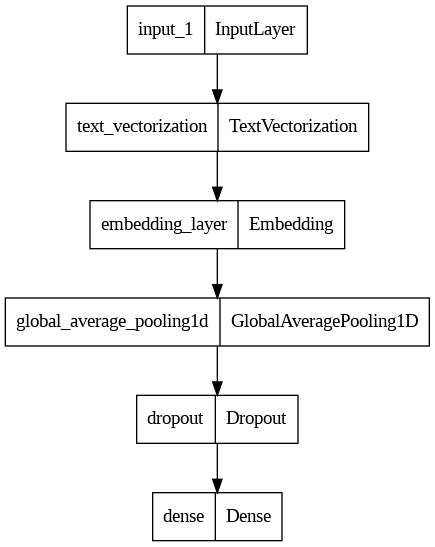

In [ ]:
plot_model(MultilayerPerceptron)

#Callbacks

Callbacks in machine learning frameworks like Keras provide a way to customize and enhance the training process. Let's discuss the benefits of two commonly used callbacks: Early Stopping and Model Checkpointing.

**Early Stopping**

Early stopping is a callback that monitors a specified metric (e.g., validation loss or accuracy) during training and stops the training process if the metric stops improving. The benefits of early stopping include:

- Preventing overfitting: Early stopping helps avoid training for too long, which can lead to overfitting. It stops training when the model's performance on the validation set starts to degrade, preventing further learning that may impact generalization.

- Saving time and computational resources: Early stopping allows you to stop the training process early if the model has already reached its optimal performance. This saves time and computational resources that would otherwise be spent on unnecessary training iterations (really important considering today's scarcity of performant GPUs).

**Model Checkpointing**

Model checkpointing is a callback that saves the model's weights or entire model at specified intervals during training. The benefits of model checkpointing include:

- Saving the best model: By saving the model weights or architecture periodically, you can track the model's progress and save the best performing model based on a chosen metric. This allows you to have checkpoints of the model at different training stages and select the one with the best validation performance.

- Enabling model resumption: If the training process is interrupted (e.g., due to a system failure or limited training time), model checkpointing ensures that the progress is saved. You can resume training from the last saved checkpoint instead of starting from scratch, avoiding the loss of progress and time.

- Facilitating model evaluation: Saved checkpoints can be loaded later for evaluation on different datasets or for making predictions on new data without the need to retrain the model.

There are a few other useful callbacks that can be implemented into training pipelines. Check out this article to find out more:

[A Guide to TensorFlow Callbacks](https://blog.paperspace.com/tensorflow-callbacks/)

Let's set up the model checkpoint and early stopping callbackes so that we can add them to our training pipeline.





In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", # watch the val loss metric
    patience=5) # if val loss does not improve for 5 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "Checkpoints/" #path where you want you saved model to be stored
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_best_only=True, #saves iteration of model with best
    monitor="val_loss")

#Hyperparameters, Loss Functions and Optimisation Schemes

## Loss Functions

The loss function measures how well the model's predictions match the actual target values during training. It quantifies the error or discrepancy between the predicted and true values. The choice of loss function depends on the problem type, such as regression or classification. For example, mean squared error (MSE) is commonly used for regression tasks, while [categorical cross-entropy](https://machinelearningmastery.com/cross-entropy-for-machine-learning/) is often used for multi-class classification. The goal is to minimize the loss function, and the model's parameters are updated based on the gradients of the loss function.

To learn more about all the loss functions, check out the following article:

[The Ultimate Guide to Loss Functions](https://neptune.ai/blog/pytorch-loss-functions#:~:text=Loss%20functions%20are%20used%20to,to%20yield%20the%20desired%20results.)


##Optimisation Schemes

The optimizer determines the strategy used to update the model's parameters during training. It computes the gradients of the loss function with respect to the model's parameters and adjusts the parameters to minimize the loss. Optimizers like Stochastic Gradient Descent (SGD), Adam, or RMSprop are commonly used. Each optimizer has its own update rules that influence the convergence speed and optimization quality. The choice of optimizer depends on factors such as the problem, network architecture, and dataset characteristics.


A great animation of optimisation schemes and their effects on minimising the loss function can be found in Emily Muller's ReCoDE: Perceptions.

The animation can be found in this [Notebook](https://imperialcollegelondon.github.io/recode-perceptions/1-cnn-intro.html) under the title 'Optimisation Schemes'.


## Hyperparameters

Hyperparameters play a crucial role in training machine learning models and can significantly impact the model's performance and generalization capability. Finding the optimal values for these hyperparameters often requires experimentation, tuning, and understanding the characteristics of the dataset and the model architecture. Commonly used hyperparameters include:

###Learning Rate

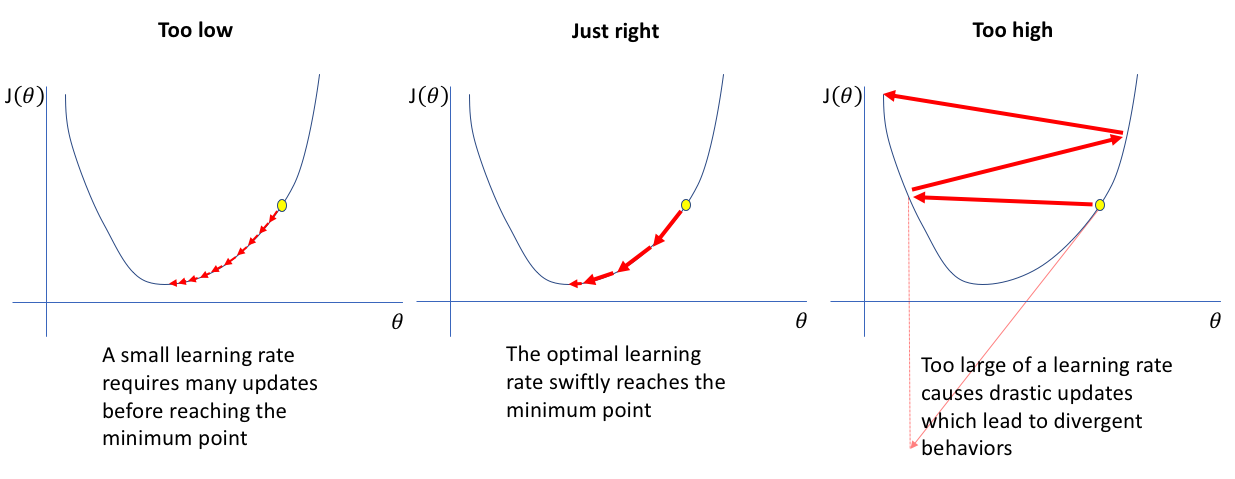



Source: [Setting the learning rate of your neural network.](https://www.jeremyjordan.me/nn-learning-rate/)

The learning rate determines the step size at each iteration during the optimization process. It controls how much the model's parameters are updated based on the calculated gradients. A learning rate that is too high can cause the optimisation of the model to overshoot a local or global minimum when minimising the loss function, while a too low learning rate can result in slow convergence to the global minimum.

###Batch Size

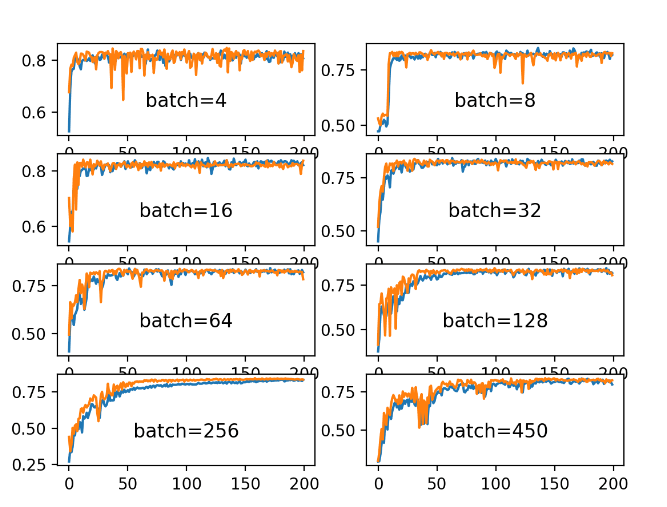

Source: [How to Control the Stability of Training Neural Networks With the Batch Size](https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/)

The batch size determines the number of training examples processed in each iteration of a training epoch. It affects the speed and stability of training. A smaller batch size provides a noisier gradient estimate but can help the model converge faster due to more frequent updates. On the other hand, a larger batch size smoothes the gradient estimate (to a point) but requires more memory and may take longer to converge. This is illustrated by the figure (classification accuracy on the y-axis)

###Dropout Rate

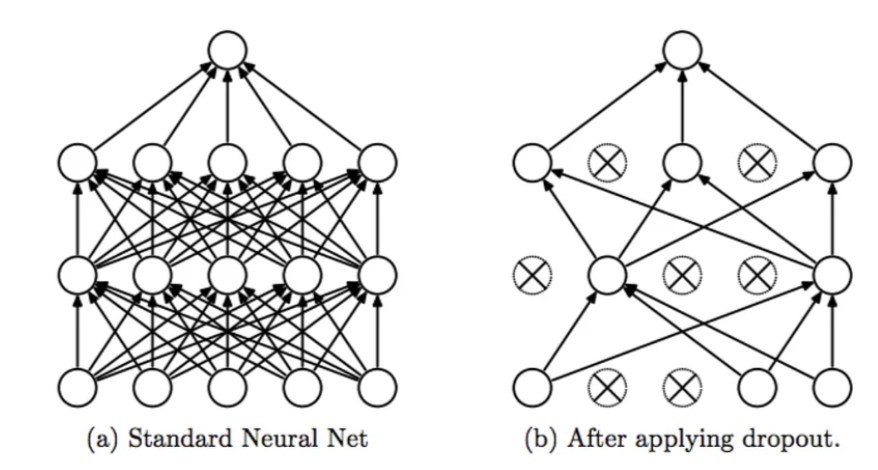

Source: [Dropout: A Simple Way to Prevent Neural Networks from Overfitting](https://jmlr.org/papers/v15/srivastava14a.html)

Dropout is a regularization technique that randomly sets a fraction of input units to 0 during training. The dropout rate determines the probability that each input unit will be zeroed out. Dropout helps prevent overfitting by reducing the reliance of the model on specific features or connections and encourages the model to learn more robust representations.

###Number of Epochs
The number of epochs specifies how many times the model iterates over the entire training dataset during training. It affects how much the model learns from the data. Too few epochs may result in underfitting, where the model hasn't captured all the patterns in the data, while too many epochs can lead to overfitting, where the model becomes too specialized to the training data and performs poorly on unseen data.


**TRY IT YOURSELF**

 *Play around with different hyperparameters, loss functions, and optimisation schemes described above to see how they affect training times and final model performance.*

In [ ]:
epochs = 20
max_length = 200

MultilayerPerceptron.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"] #metrics variable used to guide loss function optimisation
)

# We save the training logs to an object so that we can analyse training later on

history = MultilayerPerceptron.fit(X_train, #Abstract for training
                                   y_train, #Abstract classes
                                   epochs=epochs, #Defining epochs
                                   batch_size=32, #Defining the batch size
                                   validation_data=(X_test, y_test), #Test data
                                   callbacks=[early_stopping, model_checkpoint]) #Adding callbacks to the training pipeline

Epoch 1/20
3780/3780 [==============================] - 118s 30ms/step - loss: 0.3482 - accuracy: 0.8508 - val_loss: 0.2617 - val_accuracy: 0.8934
Epoch 2/20
3780/3780 [==============================] - 47s 12ms/step - loss: 0.2315 - accuracy: 0.9072 - val_loss: 0.2416 - val_accuracy: 0.9019
Epoch 3/20
3780/3780 [==============================] - 41s 11ms/step - loss: 0.1997 - accuracy: 0.9218 - val_loss: 0.2434 - val_accuracy: 0.9018
Epoch 4/20
3780/3780 [==============================] - 40s 11ms/step - loss: 0.1794 - accuracy: 0.9304 - val_loss: 0.2477 - val_accuracy: 0.9015
Epoch 5/20
3780/3780 [==============================] - 38s 10ms/step - loss: 0.1641 - accuracy: 0.9377 - val_loss: 0.2628 - val_accuracy: 0.8944
Epoch 6/20
3780/3780 [==============================] - 38s 10ms/step - loss: 0.1508 - accuracy: 0.9422 - val_loss: 0.2689 - val_accuracy: 0.8948
Epoch 7/20
3780/3780 [==============================] - 38s 10ms/step - loss: 0.1399 - accuracy: 0.9467 - val_loss: 0.2809 

#Plotting the training curve of a model

Plotting the training and loss curves of a model during the training process is valuable for the following reasons:

- Monitoring Model Performance: The training and loss curves provide insights into how well the model is learning and converging during training. By visualizing the curves, you can assess the progress of the model's performance over each epoch. If the training accuracy or loss improves steadily and converges, it indicates that the model is learning effectively. On the other hand, if there are fluctuations or no improvement, it may indicate issues with the model architecture, hyperparameters, or dataset.

- Debugging and Troubleshooting: If the model is not training as expected or the performance is not improving, plotting the training and loss curves can assist in debugging and troubleshooting. The curves can help pinpoint issues such as learning rate instability, saturation of the loss, or inadequate model capacity. By analyzing the curves, you can make informed decisions about adjusting hyperparameters, modifying the model architecture, or applying regularization techniques.

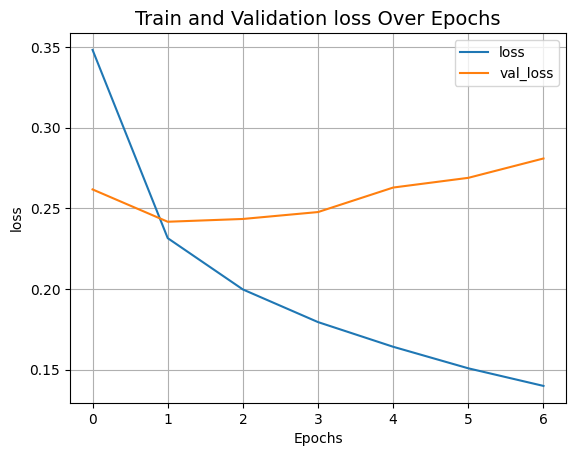

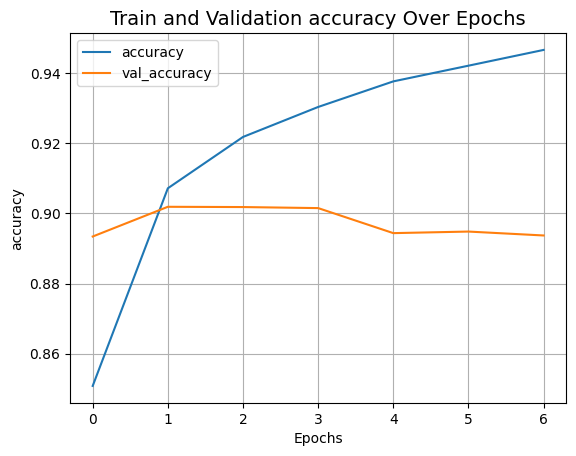

In [ ]:
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

plot_result("loss")
plot_result("accuracy")

Even though we specified training for 20 epochs, our model only trained for 6. This is because the 'validation_loss' did not improve for 5 epochs in a row, so our `EarlyStopping()` callback ended model training early.

As we can see from the graphs, our loss curve is on the way down, while our accuracy seems to be on the way up. It doesn't seem as though either of these have levelled off. This highlights one of the potential drawbacks of using callbacks like early stopping; we might stop training before our model has learned everything it can from the dataset!

**TRY IT YOURSELF**

*Try changing the metric that we define early stopping by to 'loss' or 'accuracy'. Does this yield better performance from the model.*

#Evaluating the performance of the trained model

To find out more about the different ways of evaluating trained models, and what the different evaluation metrics we calculate represent, please refer to the introduction notebook.

Let's use our `calculate_model_accuracy()` function from the Introduction notebook to calculate some evaluation metrics for our MultiLayer Perceptron.

In [ ]:
def calculate_model_accuracy(y_test, y_pred):
  accuracy = accuracy_score(y_test, y_pred) * 100
  precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

  results = {'accuracy':accuracy,
         'precision': precision,
         'recall': recall,
         'f1': f1_score}

  return results

## The Output of The Model

The first output of any neural network will be some form a numerical value.

In tasks such as regression, it may be the case that we can interpret the numerical value as the prediction being made by our model without any further manipulation. However, in many other tasks, including our task of classification, we will need to make some more changes to the output of the model before it can serve as a useful prediction.

 In our case, because we use a sigmoid activation function in the last layer of our network, the output of our network will be a single number, that can be anywhere between 0 and 1. However, the labels in our dataset are either exactly 0 or 1.

 So to get our model output to correspond to one of the class labels during our evaluation phase, we need to round each output of the model to the nearest whole number, and use that as our final prediction.

In [ ]:
# Calculating the performance metrics
MultiLayerPerceptron_Predictions = MultilayerPerceptron.predict(X_val)

#Rounding predicted values to nearest whole number (O for Non-Green, 1 for Green)
MultiLayerPerceptron_Predictions = tf.squeeze(tf.round(MultiLayerPerceptron_Predictions))

#Calling our evaluatiuon function over entire test dataset
MultiLayerPerceptron_Result = calculate_model_accuracy(Y_val, MultiLayerPerceptron_Predictions)
print(MultiLayerPerceptron_Result)

467/467 [==============================] - 1s 2ms/step
{'accuracy': 89.11500870263757, 'precision': 0.8925400305968008, 'recall': 0.8911500870263757, 'f1': 0.8910841273624326}


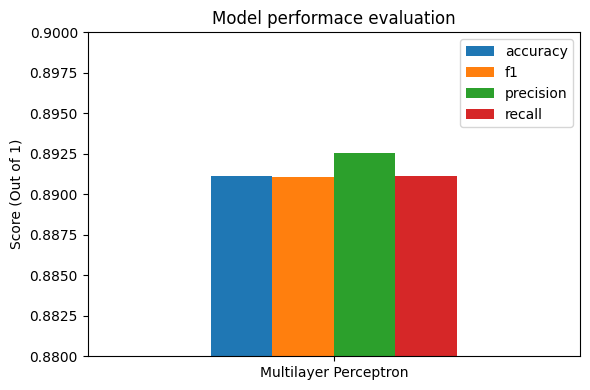

In [ ]:
#Plotting the four metrics on a bar chart
all_results = pd.DataFrame({"Multilayer Perceptron": MultiLayerPerceptron_Result})
all_results = all_results.transpose() #Formatting our dataframe so it can be plotted as a bar chart
all_results["accuracy"] = all_results["accuracy"]/100 #Normalising our accuracy score so we can plot it on the bar chart
all_results.plot(kind="bar", figsize=(6, 4))
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xticks(rotation=0, horizontalalignment="center")
plt.title("Model performace evaluation")
plt.ylabel('Score (Out of 1)')
plt.ylim(0.88, 0.9)
plt.tight_layout()

# Extension tasks
- Train a MLP using Sequential API
- Train using a GPU to see difference in speed
- Play around with Hyperparameters to see if performance can be improved
- Compare performance of this model with models from the other notebooks
- Try using trained models to predict on text that isn't in the dataset? Are there any situations where the model might get confused? Why might this be?

#What's Next?

Now that we have learned a little more about some of the important concepts in deep learning, let's apply these lessons and build more complicated models!

Check out any of these notebooks:
- PatentClassification_LSTM_Classification
- PatentClassification_Convolutional_1D_Network_Classification
- PatentClassification_Transformer_Classification